#### Requirements and Imports

In [ ]:
!pip install roboflow -q
!pip install torchmetrics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 28.2 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
from roboflow import Roboflow
from statistics import mean
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Model Training

##### Functions

In [ ]:
# Custom dataset class to transform COCO annotations
class CocoDetectionWithTransform(datasets.CocoDetection):
    def __getitem__(self, index):
        img, target = super(CocoDetectionWithTransform, self).__getitem__(index)

        # Apply transform to the image
        if self.transform is not None and not isinstance(img, torch.Tensor):
            img = self.transform(img)

        # Processing the target (annotations)
        boxes = []
        labels = []

        for obj in target:
            xmin = obj['bbox'][0]
            ymin = obj['bbox'][1]
            xmax = xmin + obj['bbox'][2]
            ymax = ymin + obj['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(obj['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Ensure there are no empty boxes
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        return img, target

In [ ]:
def collate_fn(batch):
  return tuple(zip(*batch))

def get_custom_dataset(train_data_dir: str) -> CocoDetectionWithTransform:
    # Paths to your dataset and annotations
    train_coco = f"{train_data_dir}/_annotations.coco.json"
    # Data transformations
    transform = transforms.Compose([transforms.ToTensor()])
    # Custom dataset instance
    my_dataset = CocoDetectionWithTransform(
        root=train_data_dir,
        annFile=train_coco,
        transform=transform
    )
    return my_dataset

def save_model(model, path, optimizer, epoch, loss):
    path = path.replace('.pth', '.pt')

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    torch.save(checkpoint, path)

    # Save just the model weights if needed
    model_only_path = path.replace('.pt', '_weights_only.pt')
    torch.save(model.state_dict(), model_only_path)

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    metric = MeanAveragePrecision()
    inference_times = []
    max_gpu_memory = 0

    with torch.no_grad():
        for images, targets in test_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Measure inference time
            start_time = time.time()
            predictions = model(images)
            inference_times.append(time.time() - start_time)

            # Measure GPU memory
            if torch.cuda.is_available():
                current_gpu_memory = torch.cuda.max_memory_allocated() / (1024 * 1024 * 1024)  # GB
                max_gpu_memory = max(max_gpu_memory, current_gpu_memory)

            # Update metrics
            metric.update(predictions, targets)

    # Calculate metrics
    metrics_dict = metric.compute()

    # Calculate model size
    model_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)  # MB

    results = {
        'mAP_50-95': metrics_dict['map'].item(),
        'mAP_50': metrics_dict['map_50'].item(),
        'mAP_75': metrics_dict['map_75'].item(),
        'model_size_MB': model_size,
        'avg_inference_time': mean(inference_times),
        'max_gpu_memory_GB': max_gpu_memory
    }

    return results

##### Dataset

In [ ]:
rf = Roboflow(api_key="MHamEhAkUYUWDEpRhEj3")
project = rf.workspace("try2-q1oef").project("solar-module-thermal-anaylsis-it5sj")
version = project.version(2)
dataset = version.download("coco")
dataset_root = dataset.location

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Solar-Module-Thermal-Anaylsis-2 in coco:: 100%|██████████| 386/386 [00:00<00:00, 4419.03it/s]


##### Tuning

In [ ]:
train_dir = f'{dataset_root}/train'

# Load the dataset
print("Loading dataset...")
my_dataset = get_custom_dataset(train_dir)
print('Number of samples: ', len(my_dataset))

# DataLoader instance
# data_loader = DataLoader(
#     my_dataset,
#     batch_size=2,
#     shuffle=True,
#     collate_fn=collate_fn
# )

data_loader = DataLoader(
    my_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

Loading dataset...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of samples:  302


In [ ]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')

    # Better anchor sizes for small objects
    anchor_generator = model.rpn.anchor_generator
    anchor_generator.sizes = ((8,), (16,), (32,), (64,), (128,))
    anchor_generator.aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_generator.sizes)

    # Adjusted RPN parameters
    model.rpn.nms_thresh = 0.7
    model.rpn.fg_iou_thresh = 0.7
    model.rpn.bg_iou_thresh = 0.3
    model.rpn.post_nms_top_n_train = 2000

    # Adjusted ROI parameters
    model.roi_heads.box_predictor = FastRCNNPredictor(
        in_channels=model.roi_heads.box_predictor.cls_score.in_features,
        num_classes=num_classes
    )
    model.roi_heads.nms_thresh = 0.4
    model.roi_heads.score_thresh = 0.05
    model.roi_heads.detections_per_img = 300

    return model

In [ ]:
# Initialize the model
print("Loading the model...")
model = get_model(7)

# Load the last fitted model state if available
# try:
#     checkpoint = torch.load(model_state_path)
#     model.load_state_dict(checkpoint["model_state_dict"])
#     print("Model checkpoint loaded.")
# except FileNotFoundError:
#     print("No checkpoint found. Starting training from scratch.")

Loading the model...


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 154MB/s]


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.00005, momentum=0.9, weight_decay=0.0005)

# Load optimizer state if available
if 'checkpoint' in locals():
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

lr_scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
# epoch = checkpoint.get('epoch', 0)
# min_loss = checkpoint.get('loss', float('inf'))
min_loss = float('inf')

##### Training

In [ ]:
# # Training loop
# num_epochs = 50  # Set desired number of epochs
# print(f"Started training model for {num_epochs} epochs.")

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     for i, (images, targets) in enumerate(data_loader):
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         optimizer.zero_grad()
#         losses = model(images, targets)
#         loss = sum(loss for loss in losses.values())
#         loss.backward()
#         optimizer.step()

#     # Save the model if loss is smaller
#     if loss < min_loss:
#         save_model(model, model_state_path, optimizer, epoch, loss.item())
#         min_loss = loss.item()

#     lr_scheduler.step()

#     print(f"Epoch: {epoch}, Loss: {loss.item()}")

# print("Training complete!")

In [ ]:
model_state_path = '/content/drive/MyDrive/PD/Faster R-CNN/Weights/faster_rcnn.pth'

In [ ]:
# Training configuration
num_epochs = 50
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.002,
    epochs=num_epochs,
    steps_per_epoch=len(data_loader),
    pct_start=0.3
)

# Training loop
training_start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += losses.item()

    if losses < min_loss:
        save_model(model, model_state_path, optimizer, epoch, losses.item())
        min_loss = losses.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # results = evaluate_model(model, val_loader, device)
    # print(f"Validation mAP (50-95): {results['mAP_50-95']:.4}")

total_training_time = time.time() - training_start_time
print(f"\n{num_epochs} epochs completed in {total_training_time/3600:.2f} hours.")

Epoch [1/50], Loss: 0.5101
Epoch [2/50], Loss: 0.2767
Epoch [3/50], Loss: 0.2574
Epoch [4/50], Loss: 0.2927
Epoch [5/50], Loss: 0.3136
Epoch [6/50], Loss: 0.3139
Epoch [7/50], Loss: 0.3278
Epoch [8/50], Loss: 0.3221
Epoch [9/50], Loss: 0.2910
Epoch [10/50], Loss: 0.2869
Epoch [11/50], Loss: 0.2755
Epoch [12/50], Loss: 0.2782
Epoch [13/50], Loss: 0.2738
Epoch [14/50], Loss: 0.2640
Epoch [15/50], Loss: 0.2169
Epoch [16/50], Loss: 0.2163
Epoch [17/50], Loss: 0.2283
Epoch [18/50], Loss: 0.2103
Epoch [19/50], Loss: 0.1977
Epoch [20/50], Loss: 0.1864
Epoch [21/50], Loss: 0.1718
Epoch [22/50], Loss: 0.1764
Epoch [23/50], Loss: 0.1577
Epoch [24/50], Loss: 0.1416
Epoch [25/50], Loss: 0.1473
Epoch [26/50], Loss: 0.1199
Epoch [27/50], Loss: 0.1224
Epoch [28/50], Loss: 0.1184
Epoch [29/50], Loss: 0.1191
Epoch [30/50], Loss: 0.0976
Epoch [31/50], Loss: 0.0907
Epoch [32/50], Loss: 0.0892
Epoch [33/50], Loss: 0.0809
Epoch [34/50], Loss: 0.0828
Epoch [35/50], Loss: 0.0740
Epoch [36/50], Loss: 0.0620
E

<img src='https://drive.google.com/uc?id=1jvCiNKgxSULYhYIbWygnZGv-WVTRRpNj'>

#### Model Evaluation

In [ ]:
test_dir = f'{dataset_root}/test'

# Load the test dataset
test_dataset = get_custom_dataset(test_dir)

# DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Load the trained model
model.load_state_dict(torch.load(model_state_path)['model_state_dict'])
model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

print("Testing the model...")

results = []

for images, targets in test_loader:
    images = list(image.to(device) for image in images)

    # Get predictions
    with torch.no_grad():
      outputs = model(images)

    # Process results
    for i, output in enumerate(outputs):
        print(f"Image {i + 1}")
        print("Predicted Boxes:", output['boxes'].cpu().numpy())
        print("Predicted Labels:", output['labels'].cpu().numpy())
        print("Predicted Scores:", output['scores'].cpu().numpy())
        results.append(output)

Testing the model...
Image 1
Predicted Boxes: [[4.57813324e+02 2.47393265e+02 6.24930908e+02 3.17828125e+02]
 [3.81076508e+02 2.38177536e+02 6.30099426e+02 4.41957428e+02]
 [2.61590881e+02 5.23129517e+02 3.61957489e+02 6.27111450e+02]
 [4.82413300e+02 2.07149780e+02 5.10000000e+02 2.38247437e+02]
 [0.00000000e+00 8.47048264e+01 2.19241013e+02 3.60032623e+02]
 [3.62564606e+02 4.19738342e+02 6.40000000e+02 6.35419495e+02]
 [3.83870758e+02 3.07690094e+02 5.15157288e+02 4.11269867e+02]
 [3.90133514e+02 7.47726364e+01 6.40000000e+02 2.28671539e+02]
 [3.23353119e+02 1.53604736e+02 3.63802826e+02 1.80847443e+02]
 [2.30209763e+02 1.76819931e+02 6.30675903e+02 6.38485718e+02]
 [4.38138916e+02 0.00000000e+00 5.23586609e+02 9.21868820e+01]
 [1.17696144e+02 0.00000000e+00 4.31881927e+02 1.60837357e+02]
 [2.49151230e+02 1.89419418e+02 6.23782471e+02 6.33525391e+02]
 [4.40304901e+02 2.72201538e-01 5.24707153e+02 9.59834518e+01]
 [4.37174866e+02 0.00000000e+00 5.22981628e+02 8.76791611e+01]
 [4.67177

In [ ]:
# Load ground-truth annotations
coco_gt = COCO(f"{test_dir}/_annotations.coco.json")

# Format predictions for COCOeval
coco_predictions = []
for i, output in enumerate(results):
    for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
        xmin, ymin, xmax, ymax = box.tolist()
        coco_predictions.append({
            "image_id": test_dataset.ids[i],
            "category_id": label.item(),
            "bbox": [xmin, ymin, xmax - xmin, ymax - ymin],
            "score": score.item(),
        })

# Load predictions into COCO
coco_dt = coco_gt.loadRes(coco_predictions)

# Initialize COCO evaluation
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.786
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.739
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.509
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [ ]:
# Define a function to visualize predictions
def visualize_predictions(image_path, predictions, label_map, score_threshold=0.5):
    # Open and display the image
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    ax = plt.gca()

    # Draw boxes and labels
    for box, label, score in zip(predictions['boxes'].cpu(), predictions['labels'].cpu(), predictions['scores'].cpu()):
        if score >= score_threshold:
            xmin, ymin, xmax, ymax = box
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                        fill=False, edgecolor='red', linewidth=2))
            ax.text(xmin, ymin - 10, f"{label_map[label.item()]}: {score:.2f}",
                    color='red', fontsize=8, backgroundcolor='white')

    plt.axis('off')
    plt.show()

label_map = {
    1: 'multi-cell',
    2: 'open-circuit',
    3: 'partial-shading',
    4: 'short-circuit',
    5: 'single-cell',
    6: 'substring'
}

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


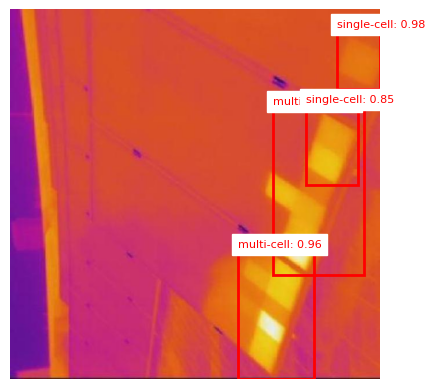

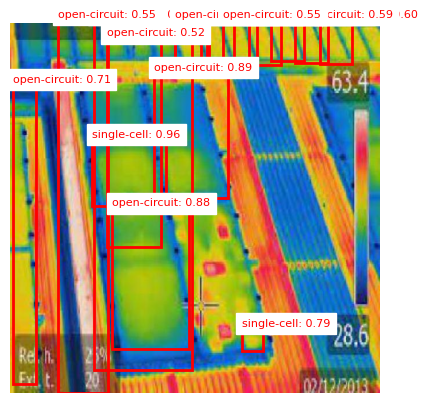

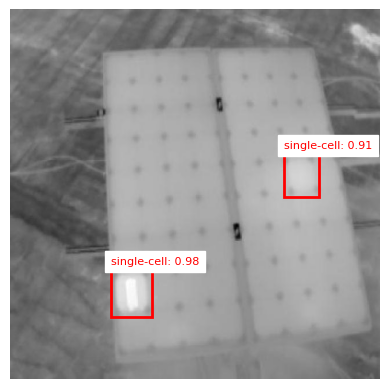

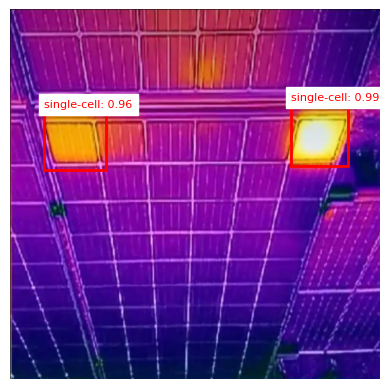

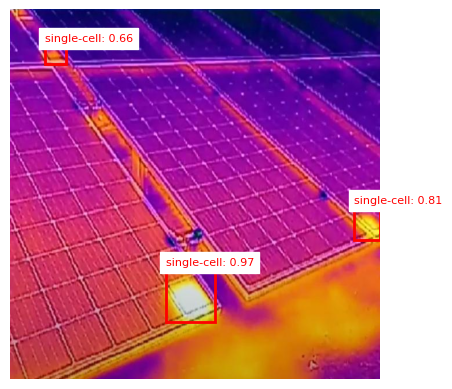

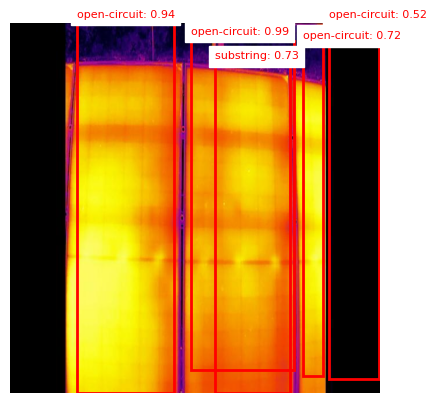

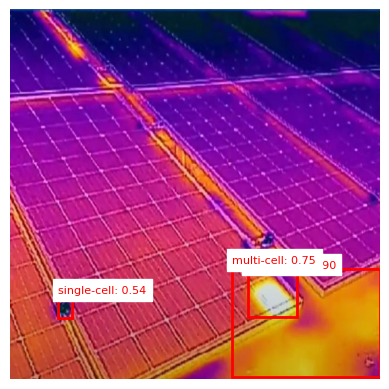

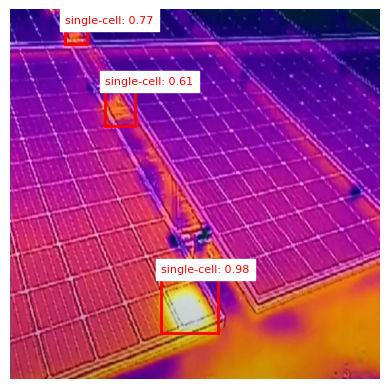

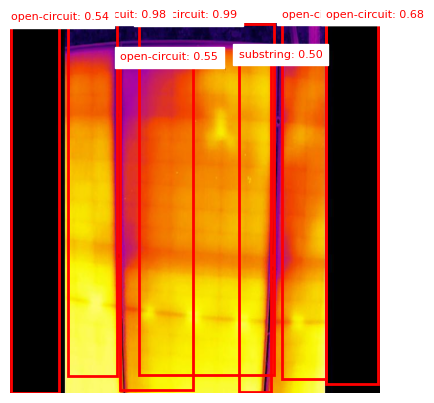

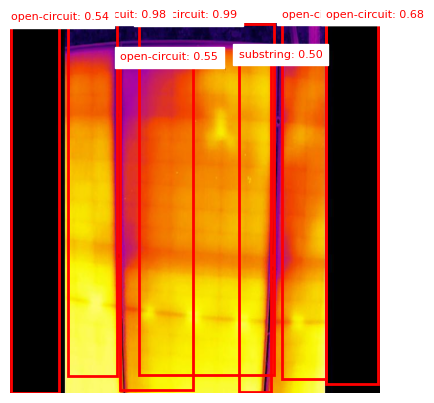

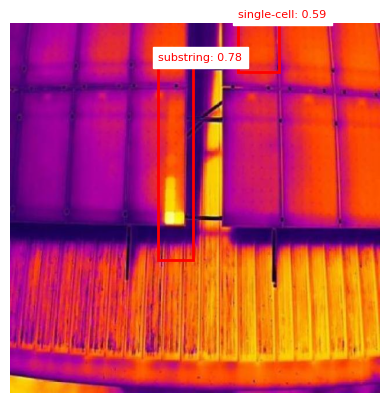

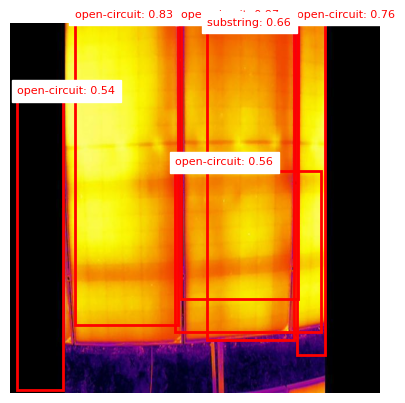

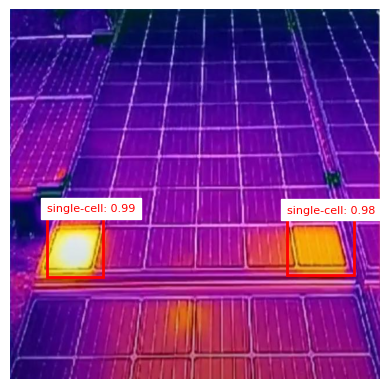

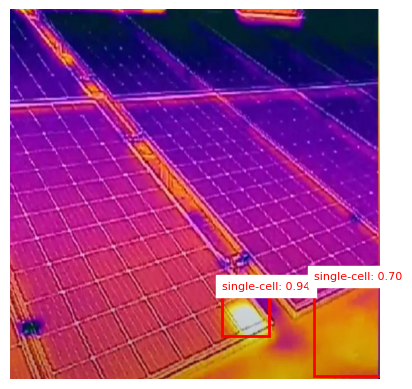

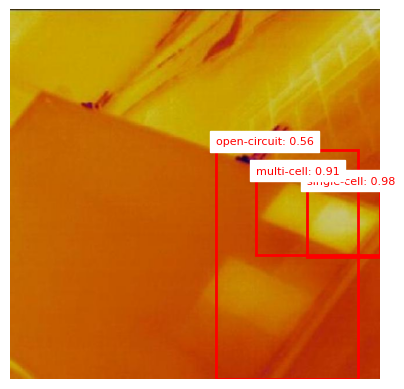

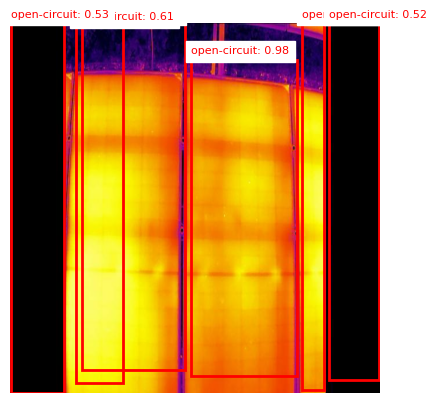

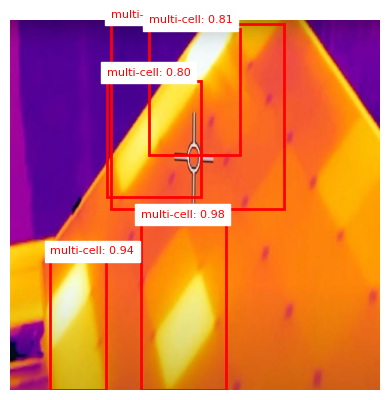

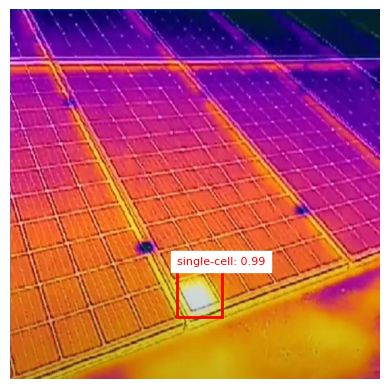

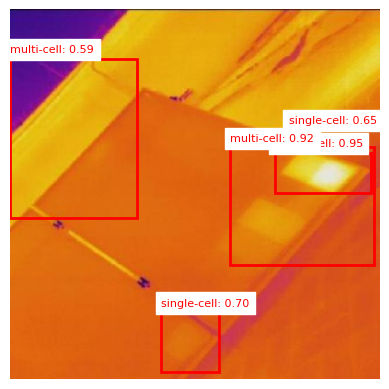

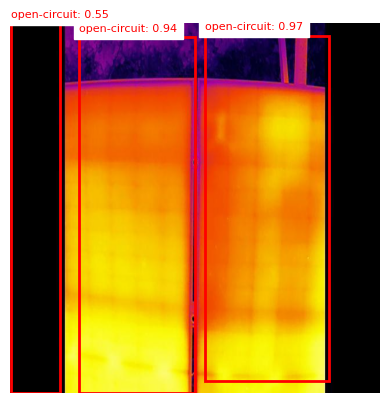

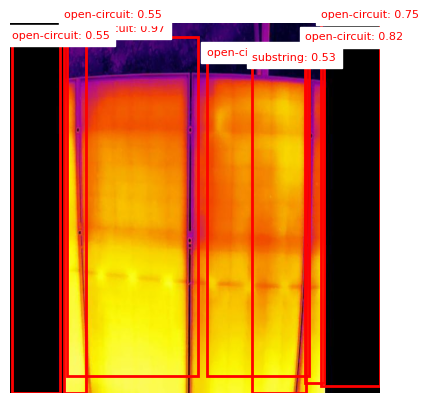

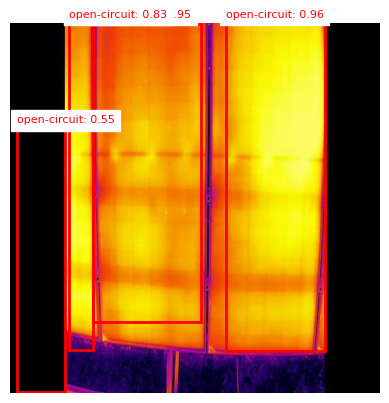

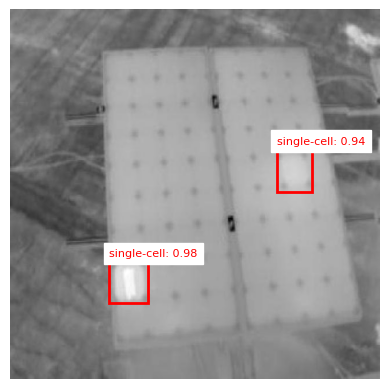

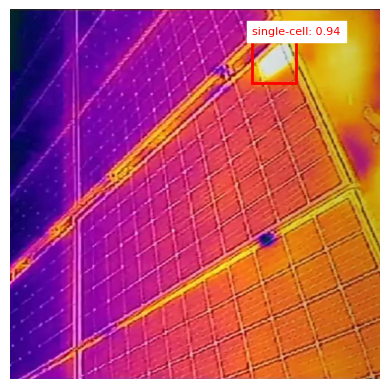

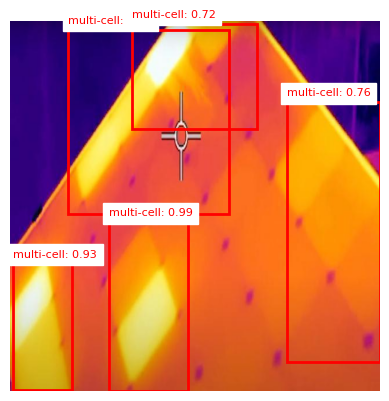

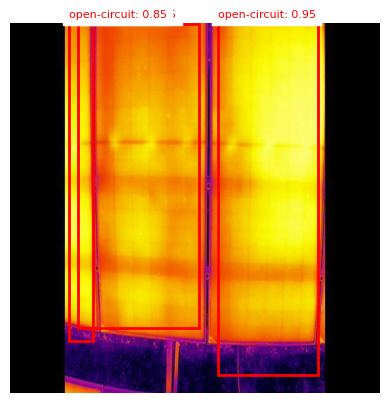

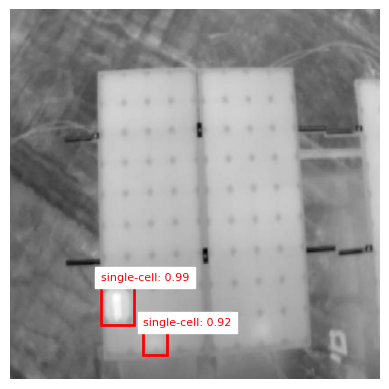

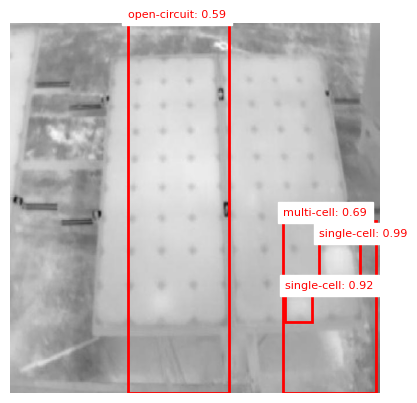

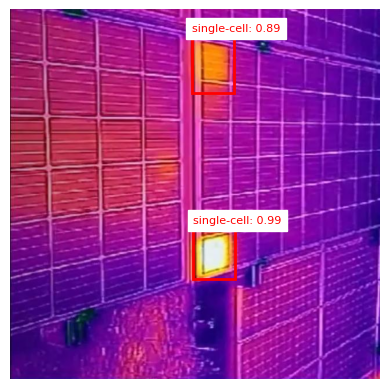

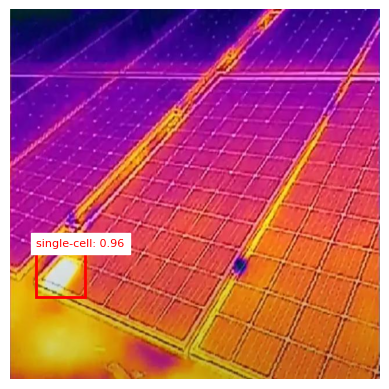

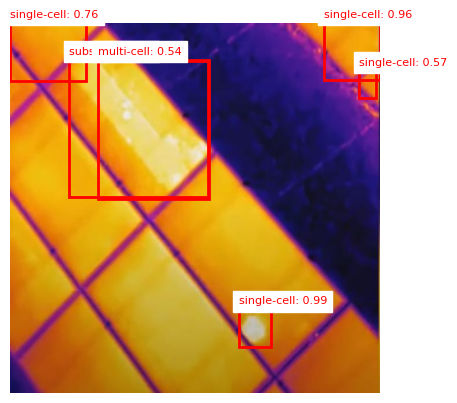

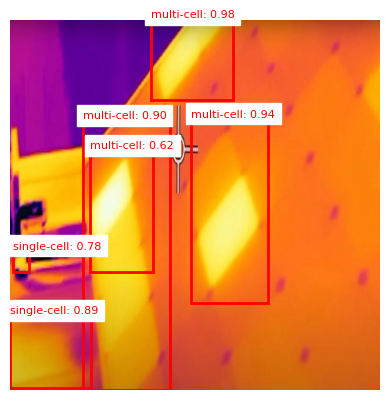

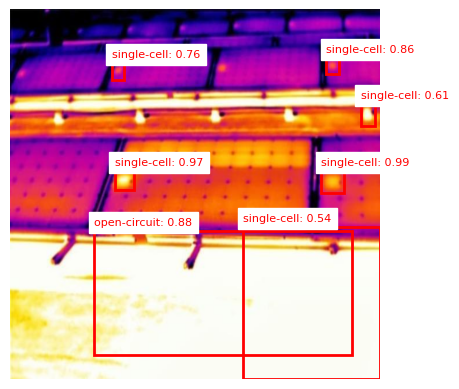

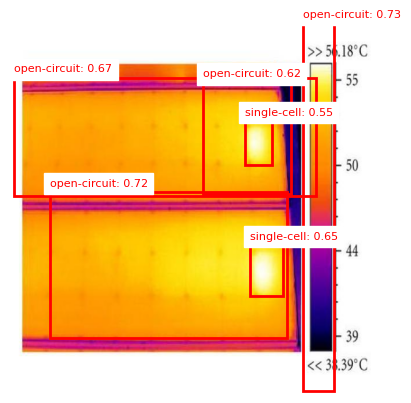

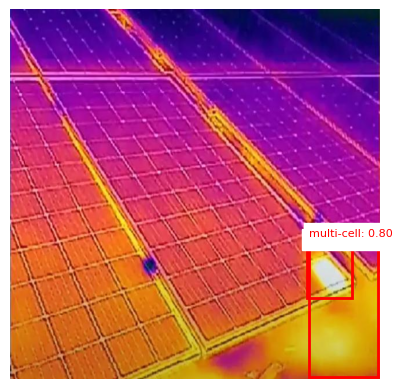

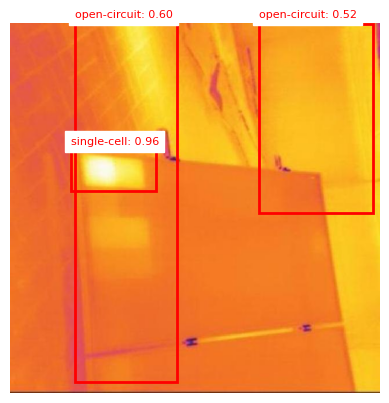

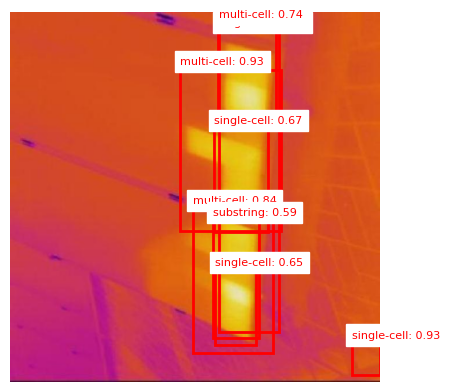

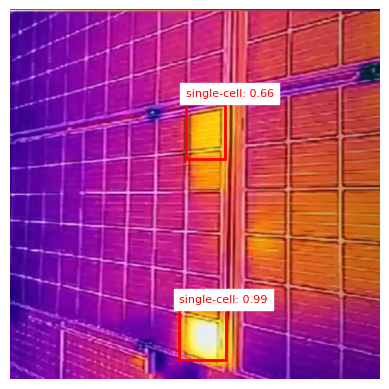

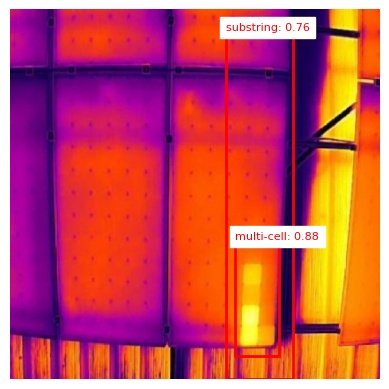

In [ ]:
# Load the trained model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load(model_state_path)['model_state_dict'])
model.eval().to(device)

# Path to a sample test image
test_image_dir = '/content/Solar-Module-Thermal-Anaylsis-2/test'

for filename in os.listdir(test_image_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        test_image_path = os.path.join(test_image_dir, filename)

    # Preprocess the image
    image = Image.open(test_image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    # Run inference
    with torch.no_grad():
        predictions = model(image_tensor)[0]

    # Display predictions
    visualize_predictions(test_image_path, predictions, label_map)

### Evaluation of constraints

In [ ]:
# After training, evaluate the model
results = evaluate_model(model, test_loader, device)

# Print results
print('Model Evaluation Results:')
print(f'Model size: {results["model_size_MB"]:.2f} MB')
print(f'mAP50-95: {results["mAP_50-95"]:.4f}')
print(f'Average inference time: {results["avg_inference_time"]:.2f} seconds')
print(f'Peak GPU memory usage during training: {results["max_gpu_memory_GB"]:.2f} GB')

Model Evaluation Results:
Model size: 70.11 MB
mAP50-95: 0.5081
Average inference time: 0.17 seconds
Peak GPU memory usage during training: 6.95 GB


`50 epochs completed in 0.215 hours.`